# Libraries

In [1]:
import numpy as np
import pandas as pd
# sm - https://towardsdatascience.com/simple-and-multiple-linear-regression-in-python-c928425168f9
#import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
#Which search to use?
from sklearn.model_selection import GridSearchCV#, RandomizedSearchCV
#For max_depth
from sklearn.tree import DecisionTreeClassifier, plot_tree

np.random.seed(50)

#Plotting Params

%matplotlib inline

#plt.rcParams['figure.figsize'] = [20.0, 7.0]
#plt.rcParams.update({'font.size': 22,})

#sns.set_palette('viridis')
#sns.set_style('white')
#sns.set_context('talk', font_scale=0.8)

In [30]:
#Get all data
data = pd.read_csv(r'assignment1-2019-data.csv')
from sklearn.datasets import load_digits, load_iris, load_breast_cancer, load_boston

digits = load_digits()
iris = load_iris()
breast_cancer = load_breast_cancer()
boston = load_boston()

# Tuning Maximum Depth

- Specify Parameters before running
- Value impacts quality and performance of model
- Goal is to maximise **performance** and **intelligibility**
- Rule for performance vs complexity
    - Maximum depth can increase by 1 for a minimum of a 2% improvement in accuracy
- Dividing data into k-folds can be done by sklearn?
    - Using 6-folds
- Mximum depth as a measure of complexity
    - Extra layer I consider to be worthwhile for 2% improvement in accuracy. Needs to be low for computational cost for testing. In real world situation when identifying, for example, breast cancer, it would be more like a 0.2% improvement would be worth it.
    - Started off with max_depth = 8
    - By testing on the digits dataset, determined that max depth would be deeper based on my sacrifice criteria.

In [3]:
#Code for Hyper-parameter Tuning goes here.
#Not using this, used to get my head around 

def get_h_params(dataset):

    n_samples = len(dataset.data)
    X = dataset.data.reshape((n_samples, -1))
    y = dataset.target

    kf_data = KFold(n_splits = 6)

    #Split data by kfold
    for train_index, test_index in kf_data.split(X):
        #print("TRAIN:", train_index, "\n", "TEST:", test_index)
        #print(len(train_index), len(test_index))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        #Set the parameters by cv
        tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                             'C': [1, 10, 100, 1000]},
                            {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
        
        scores = ['precision', 'recall']
        
        for score in scores:
            for score in scores:
                print("# Tuning hyper-parameters for %s." % score, 
                      "this may take a while...")
                print()

                clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                                   scoring='%s_macro' % score)
                clf.fit(X_train, y_train)

                print("Best parameters set found on development set:")
                print()
                print(clf.best_params_)
                print()
                print("Grid scores on development set:")
                print()
                means = clf.cv_results_['mean_test_score']
                stds = clf.cv_results_['std_test_score']
                for mean, std, params in zip(means, stds, clf.cv_results_['params']):
                    print("%0.3f (+/-%0.03f) for %r"
                          % (mean, std * 2, params))
                print()

                print("Detailed classification report:")
                print()
                print("The model is trained on the full development set.")
                print("The scores are computed on the full evaluation set.")
                print()
                y_true, y_pred = y_test, clf.predict(X_test)
                print(classification_report(y_true, y_pred))
                print()
        

In [4]:
#test
#get_h_params(breast_cancer)

In [34]:
dataset = breast_cancer
#This will become a function
def classifier(dataset, depth):
    #Split into test and train 30:70
    n_samples = len(dataset.data)
    X = dataset.data.reshape((n_samples, -1))
    y = dataset.target
    X_train_dataset, X_test_dataset, y_train_dataset, y_test_dataset = train_test_split(X, y, test_size=0.30, random_state=50)
    #print(len(X_train_dataset), len(X_test_dataset))

    #K-fold on training data
    kf_data = KFold(n_splits = 6)
    for train_index, test_index in kf_data.split(X_train_dataset):
        #print("TRAIN:", train_index, "\n", "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        #Classification
        estimator = DecisionTreeClassifier(max_depth=depth) #max_depth global
        estimator.fit(X_train, y_train)

        #Tree structure arrays
        n_nodes = estimator.tree_.node_count
        children_left = estimator.tree_.children_left #id of left children
        children_right = estimator.tree_.children_right #id of right children
        feature = estimator.tree_.feature #feature used for splitting node
        threshold = estimator.tree_.threshold #thsh value at the node

        #i = 0
        #for X in X_test_dataset:
            #y = y_test_dataset[i]
            #prediction = predict(X)
            #print(prediction, y)
            #i+=1

        #Plot
        plot_tree(estimator.fit(dataset.data, dataset.target), filled = True, rounded = True)
        #dot_data = export_graphviz(clf, out_file=None)
        #graph = graphviz.Source(dot_data)
        #graph.render("digits")

        #accuracy = accuracy_score(y_true, y_pred)
    return(estimator.score(X_test_dataset, y_test_dataset))
        
#Test


Depth = 11
[(1, 0.6888888888888889), (2, 0.9777777777777777), (3, 0.9777777777777777), (4, 1.0), (5, 1.0), (6, 1.0), (7, 1.0), (8, 1.0), (9, 1.0), (10, 1.0), (11, 1.0)]


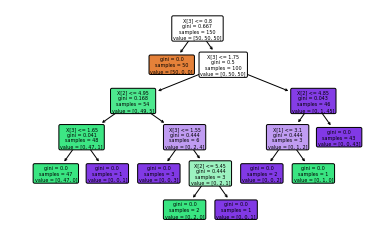

In [101]:
#Iris
exit = False
depth = 1
prev = 0
accuracy = []
while depth <= 11:
    value = classifier(iris, depth)
    if (value - prev) > 0.02:
        prev = value
        accuracy.append((depth, value))
    else:
        exit = True
        accuracy.append((depth, value))
        
    depth += 1
print("Depth =",depth-1)
print(accuracy)
    
#data = pd.DataFrame(accuracy, columns = 'Accuracy')

Depth = 11
[(1, 0.935672514619883), (2, 0.9122807017543859), (3, 0.9883040935672515), (4, 0.9883040935672515), (5, 0.9941520467836257), (6, 1.0), (7, 1.0), (8, 1.0), (9, 1.0), (10, 1.0), (11, 1.0)]


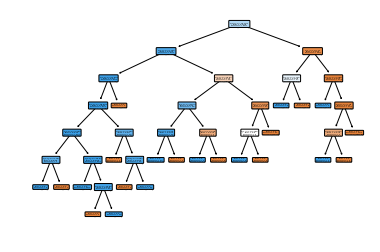

In [102]:
#Breast Cancer
exit = False
depth = 1
prev = 0
accuracy = []
while depth <= 11:
    value = classifier(breast_cancer, depth)
    if (value - prev) > 0.02:
        prev = value
        accuracy.append((depth, value))
    else:
        exit = True
        accuracy.append((depth, value))
        
    depth += 1
print("Depth =",depth-1)
print(accuracy)
    
#data = pd.DataFrame(accuracy, columns = 'Accuracy')

Depth = 11
[(1, 0.2222222222222222), (2, 0.3425925925925926), (3, 0.4888888888888889), (4, 0.5962962962962963), (5, 0.7092592592592593), (6, 0.8148148148148148), (7, 0.8814814814814815), (8, 0.9296296296296296), (9, 0.9648148148148148), (10, 0.987037037037037), (11, 0.9944444444444445)]


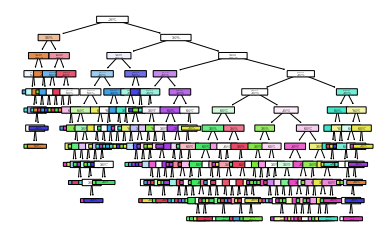

In [103]:
#Digits
exit = False
depth = 1
prev = 0
accuracy = []
while depth <= 11:
    value = classifier(digits, depth)
    if (value - prev) > 0.02:
        prev = value
        accuracy.append((depth, value))
    else:
        exit = True
        accuracy.append((depth, value))
        
    depth += 1
print("Depth =",depth-1)
print(accuracy)
    
#data = pd.DataFrame(accuracy, columns = 'Accuracy')

In [39]:
print(boston.data.shape)

# define the data/predictors as the pre-set feature names  
df = pd.DataFrame(boston.data, columns=boston.feature_names)

##Prints the data of the first 5 (Yus!)
print(df.head())

#boston.target[[11, 50, 90]]

#print (len(boston.data))

(506, 13)
      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  
0     15.3  396.90   4.98  
1     17.8  396.90   9.14  
2     17.8  392.83   4.03  
3     18.7  394.63   2.94  
4     18.7  396.90   5.33  


# DT vs Linear Models

- Hypothesis which performs well on one class of problems may be bad on another.
- Need to **Construct a binary classsification problem**
    - Define a function that describes the class lable of a point.
    - We know T/F value since we define the problem.
    - Generate training and testing data where P and N represent the + and - classes.
- Investigate how tree sizes affect performance
- Create visualisation of actual and learned class boundaries
- Discuss what would happen if the problem was Rd instead of R2

~~~
DTree(examples, features) # returns a tree
    if all examples are in one class:
        return a leaf node with that class label;
    elif the set of features is empty:
        return a leaf node with the most common class label in examples;
    else:
        create a new decision (condition) node R;
        pick a categorical feature F (or a numeric feature and a threshold);
        for each possible outcome v_i of R:
            add an out-going edge E_v_i to node R;
            let examples_i be the subset of examples that result in outcome v_i;
            if examples_i is empty:
                attach to E_v_i a leaf node (label) that is 
                                the most common in examples;
            else:
                attach to E_v_i the result of DTree(examples_i, features \ {F});
        return the subtree rooted at R.
~~~

In [7]:
#DT
df_x = pd.DataFrame(boston.data, columns = boston.feature_names)
df_y = pd.DataFrame(boston.target)

model = linear_model.LinearRegression()

x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size = 0.2, random_state = 50)

model.fit(x_train, y_train)

results = model.predict(x_test)
print(results[0] )
print(y_test)

[12.27194543]
        0
365  27.5
313  21.6
461  17.7
158  24.3
333  22.2
372  50.0
352  18.6
379  10.2
382  11.3
42   25.3
23   14.5
295  28.6
446  14.9
198  34.6
359  22.6
427  10.9
491  13.6
301  22.0
121  20.3
294  21.7
230  24.3
97   38.7
160  27.0
420  16.7
67   22.0
458  14.9
444  10.8
242  22.2
88   23.6
326  23.0
..    ...
317  19.8
46   20.0
297  20.3
331  17.1
389  11.5
148  17.8
376  13.9
29   21.0
493  21.8
116  21.2
38   24.7
456  12.7
115  18.3
270  21.1
219  23.0
293  23.9
350  22.9
336  19.5
25   13.9
191  30.5
204  50.0
429   9.5
442  18.4
411  17.2
151  19.6
304  36.1
421  14.2
497  18.3
65   23.5
87   22.2

[102 rows x 1 columns]


# Regression on Mixed Data Types

- Given data set for a regression problem
- Need to train linear regression model
- Needs to be linear in weights and features 
- Has a categorical feature with more than two levels
- Use entire dataset for training
- Needs to output
    - Mean Squared Error
    - R^2
    - Round coefficients to intigers
    - Write a case based definition of the functions identified
        - Linear expression of input variables
        - One expression per level of variable
    - Describe how regression was used
    - How a new datapoint can be assigned a predicted value

In [8]:
#Code for Regression goes here.